In [97]:
import os
import numpy as np
from PIL import Image
import random

import matplotlib.pyplot as plt

import torch
import torchvision

# Creating a custom dataset class
class ImageDataset(torch.utils.data.Dataset):
    
    def __init__(self, dir, transform=None):
        self.data_dir = dir
        self.images = []
        self.labels = []
        self.transform = transform

        # classi : mi baso sulle sottocartelle
        self.classes = sorted(os.listdir(dir))  
        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.classes)}
        
        for cls_name in self.classes:
            cls_folder = os.path.join(dir, cls_name)
            for fname in os.listdir(cls_folder):
                self.images.append(os.path.join(cls_folder, fname))
                self.labels.append(self.class_to_idx[cls_name])

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image_np = np.array(Image.open(self.images[index])) # forza grayscale
        image = torch.from_numpy(image_np).unsqueeze(0) / 255.0

        # Applying the transform
        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        
        return image, label

Number of training examples: 73554


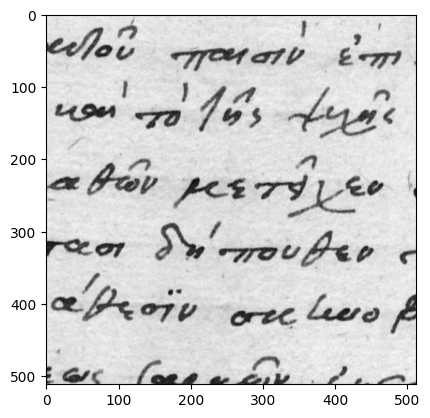

In [87]:
# Replace the path with the path to your dataset
data_path = '../data/patches/gsc'

# Creating a dataset object with the path to the dataset
dataset = ImageDataset(data_path)

# Getting the length of the dataset
dataset_length = len(dataset)

# Printing the length of the dataset
print('Number of training examples:',dataset_length)

# Generating a random index within the dataset length
random_index = random.randint(0, dataset_length - 1)

# Plotting the randomly selected image
plt.imshow(dataset[random_index].squeeze(0),cmap="gray")
plt.show()

In [88]:
class SaltAndPepper(object):

    def __init__(self, generator, amount=0.05):
        self.amount = amount
        self.generator = generator

    #definisco la trasformazione

    def __call__(self, image):

        #dimensioni
        if image.ndim == 3:
            _, h, w = image.shape
        else:
            h, w = image.shape


        number_of_pixels = int(h * w * self.amount)

        # Pick a random y coordinate
        y_coord=torch.randint(0, h, (number_of_pixels,), generator=self.generator)
        
        # Pick a random x coordinate
        x_coord=torch.randint(0, w, (number_of_pixels,), generator=self.generator)
        
        # Color that pixel to white
        image[:, y_coord, x_coord] = 1.0
            
        # Randomly pick some pixels in
        # the image for coloring them black
        # Pick a random number between 300 and 10000 
        
        # Pick a random y coordinate
        y_coord=torch.randint(0, h, (number_of_pixels,), generator=self.generator)
        
        # Pick a random x coordinate
        x_coord=torch.randint(0, w, (number_of_pixels,), generator=self.generator)
        
        # Color that pixel to black
        image[:, y_coord, x_coord] = 0.0

        return image
    

Number of training examples: 20256


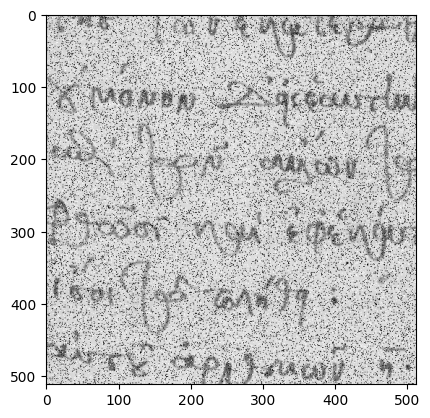

In [8]:
rng = torch.Generator().manual_seed(2025)# crea un generatore

# Replace the path with the path to your dataset
data_path = '../data/patches/gsc/albini'

# Creating a dataset object with the path to the dataset
dataset = ImageDataset(data_path, transform=SaltAndPepper(generator= rng, amount= 0.1))

# Getting the length of the dataset
dataset_length = len(dataset)

# Printing the length of the dataset
print('Number of training examples:',dataset_length)

# Plotting the randomly selected image
plt.imshow(dataset[random_index].squeeze(0),cmap='gray')
plt.show()

Number of training examples: 73554
1


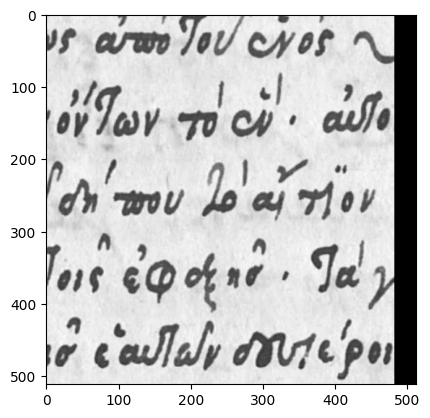

In [108]:
from torchvision.transforms import v2

rng = torch.Generator().manual_seed(2025)  # crea un generatore

# Replace the path with the path to your dataset
data_path = '../data/patches/gsc'

my_transform = v2.Compose([
    v2.RandAugment(2,4)
])

# Creating a dataset object with the path to the dataset
dataset = ImageDataset(data_path, transform=my_transform)

# Getting the length of the dataset
dataset_length = len(dataset)

# Printing the length of the dataset
print('Number of training examples:',dataset_length)

random_index = random.randint(0, len(dataset)-1)
# Plotting the randomly selected image


img, label = dataset[random_index]
print(f'{label}')
plt.imshow(img.squeeze(0),cmap='gray')
plt.show()

In [77]:
from torch.utils.data import Dataset, random_split

dataset = ImageDataset(data_path, transform=my_transform)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, val_size], generator=rng)

In [109]:
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,

    batch_size = 100,

    shuffle = True,

    num_workers= 2 
)

print('Number of batches:',len(train_dataloader))

test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,

    batch_size = 1,

    shuffle = False,

    num_workers= 2 
)

print('Number of batches:',len(test_dataloader))

Number of batches: 163
Number of batches: 4052


In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === MODEL ===
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Adattiamo la prima conv per grayscale
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

Using device: cuda
